In [32]:
import sys
import numpy
import pickle
import matplotlib.pyplot as plt, pandas as pd, matplotlib as mpl, random
def utkarshGrid(): plt.minorticks_on() ; plt.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; plt.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
def utkarshGridAX(ax): ax.minorticks_on() ; ax.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; ax.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
mpl.rcParams['legend.frameon'], mpl.rcParams['figure.autolayout'] = False, True,
colour = ["dodgerblue", "goldenrod", "crimson", "teal", "yellowgreen", "grey"]
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Palatino"],})
def utkarshWrapper(): plt.legend();plt.utkarshGrid() ;plt.gca().tick_params(direction='in', which='both', right=True, top=True); plt.tight_layout(); return None
def utkarshWrapperAX(ax): utkarshGridAX(ax); ax.tick_params(direction='in', which='both', right=True, top=True); return None; 
plt.utkarshGrid = utkarshGrid; plt.utkarshWrapper = utkarshWrapper
def colour_sample(n = 2, col = colour, seed = 7236): random.seed(seed) ; return random.sample(colour, n)
plt.rcParams["image.cmap"] = "Set2" # I recommend, Set2, Dark2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour) # Use your own OR plt.cm.Set2.colors

In [33]:
%reload_ext autoreload
%autoreload 2
from run_inference import *
from postprocessing_functions import *

In [34]:
mcmc = None
path = f"results/prior"
mcmc = pickle_read(path)
prior_samples = infer_samples(mcmc)

In [35]:
mcmc = None
path = f"results/posterior"
mcmc = pickle_read(path)
posterior_samples = infer_samples(mcmc)
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
         A[0]      0.76      0.23      0.83      0.40      1.00   4600.75      1.00
   alpha_1[0]     -3.94      0.98     -4.17     -5.00     -2.82   4174.70      1.00
   alpha_2[0]     -3.04      0.41     -3.06     -3.72     -2.37   3549.88      1.00
    beta_1[0]      0.01      0.55     -0.04     -0.85      0.91   5966.10      1.00
    beta_2[0]      1.14      0.93      1.03     -0.44      2.49   3074.15      1.00
  eta_high[0]     26.96     13.11     27.19      8.71     49.62   7863.87      1.00
   eta_low[0]     27.38     13.52     27.77      8.48     49.99   6757.23      1.00
   eta_max[0]      6.53      1.75      6.49      4.10      9.74   5644.64      1.00
   eta_min[0]     30.04     11.57     30.14     13.02     48.99   7330.81      1.00
gamma_high[0]      6.65      1.00      6.86      5.10      8.00   5781.92      1.00
 gamma_low[0]      2.70      0.52      2.58      2.00      3.52   5615.50  

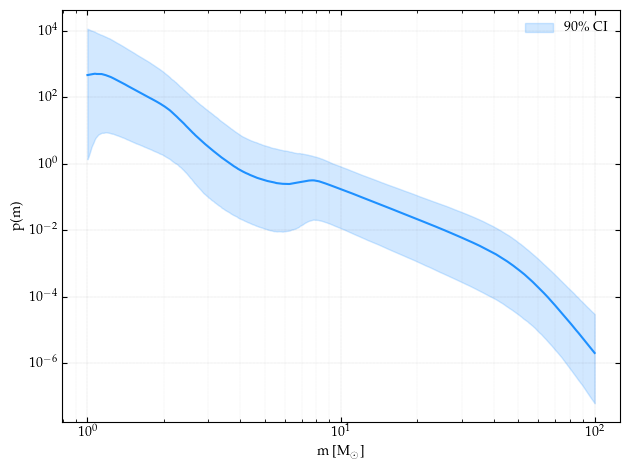

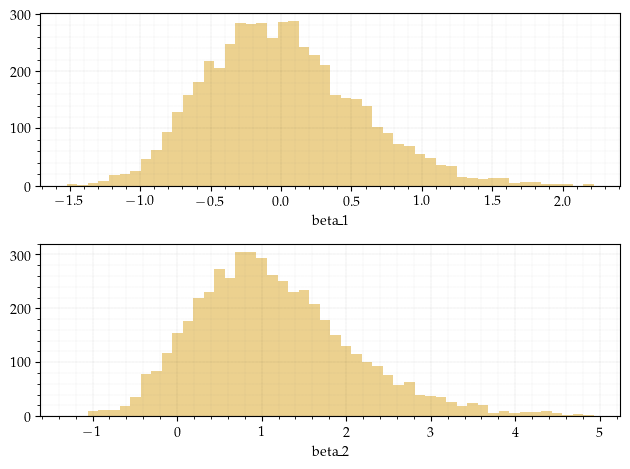

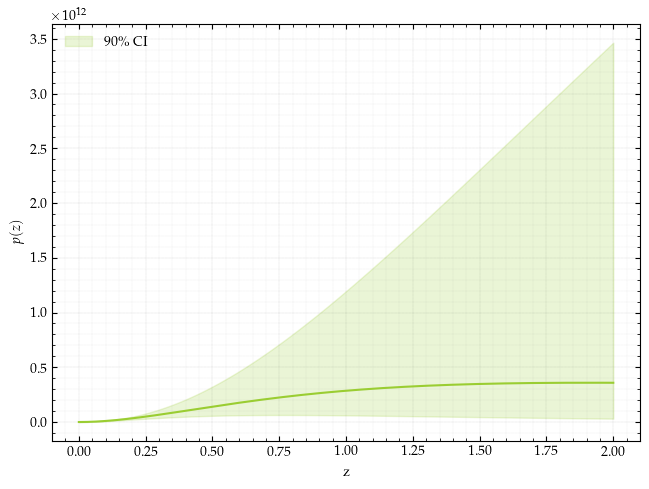

In [36]:
try:
    from config.mass1d_func import pdb as mass1d_func
except:
    from config.mass1d_func import multi_pdb as mass1d_func
# from config.spin_func import prob_chi, prob_costilt
from config.distance_func import powerlaw_redshift

plot_p_m(posterior_samples, function=mass1d_func)
plot_p_pairing(posterior_samples)
# plot_p_chi(posterior_samples, function=prob_chi)
# plot_p_costilt(posterior_samples, function=prob_costilt)
plot_p_z(posterior_samples, function=powerlaw_redshift)
plt.show()

In [37]:
import os
import arviz as az

if os.path.exists("results/trace1.png") or os.path.exists("results/trace2.png") or os.path.exists("results/trace.png"):
    print("Trace plots already exist, skipping generation")
else:
    print("Generating trace plots")
    data = az.from_numpyro(mcmc)
    var_names_lst = get_non_deterministic_params(mcmc)

    if len(var_names_lst) >= 20:
        cut1 = var_names_lst[:20]
        cut2 = var_names_lst[20:]

        assert len(cut1) + len(cut2) == len(var_names_lst)

        az.plot_trace(data, var_names=cut1, compact=True)
        plt.savefig("results/trace1.png")
        az.plot_trace(data, var_names=cut2, compact=True)
        plt.savefig("results/trace2.png")
    else:
        az.plot_trace(data, var_names=var_names_lst, compact=True)
        plt.savefig("results/trace.png")

Trace plots already exist, skipping generation


In [38]:
from model_vector import model_vector

import os

# try:
#     os.remove("results/postprocessed_samples")
# except: pass

if os.path.exists("results/postprocessed_samples"):
    with open("results/postprocessed_samples", "rb") as f:
        postprocessed_posterior_samples = pickle.load(f)
else:
    postprocessed_posterior_samples = add_postprocessing_effects(posterior_samples, model_vector)
    with open("results/postprocessed_samples", "wb") as f:
        pickle.dump(postprocessed_posterior_samples, f)

In [39]:
config = configparser.ConfigParser()
config.read('config/config.ini')
event_folder_name = config["DIRECTORIES"]["event_folder_name"]
event_file_name = config["DIRECTORIES"]["event_file_name"]
translate_dir = "../../"
events = numpy.loadtxt(translate_dir+event_folder_name+event_file_name, dtype=str)

for event_i in tqdm(range(len(postprocessed_posterior_samples["neff_events"].T))):
    neff = postprocessed_posterior_samples["neff_events"].T[event_i]
    filename = events[event_i][:14]
    plot_neff(neff, filename)
    plt.close()

100%|██████████| 66/66 [00:20<00:00,  3.22it/s]


In [40]:
# plot_neff(postprocessed_posterior_samples["neff_selection"], "selection")
# plot_neff(postprocessed_posterior_samples["neff_events_total"], "events_total")
# plot_neff(postprocessed_posterior_samples["loglike_var"], "loglike_var")
# plt.xlabel("loglike_var")
# plt.axvspan(1, max(postprocessed_posterior_samples["loglike_var"]), color = "red", label = "Var samples greater than 1", alpha = 0.2)
# plt.savefig("results/loglike_var.png")
#
# plt.figure()
# plot_corner(postprocessed_posterior_samples["sig_peak1"], postprocessed_posterior_samples["neff_selection"], "sig_peak1", "neff_selection")
# plt.figure()
# plot_corner(postprocessed_posterior_samples["sig_peak1"], postprocessed_posterior_samples["neff_events_total"], "sig_peak1", "neff_all_pe")

In [41]:
params = get_non_deterministic_params(mcmc) + ["neff_events_total", "neff_selection"]
params_samples = np.array([postprocessed_posterior_samples.get(key).flatten() for key in params]).T
corner.corner(params_samples, labels=params, color="dodgerblue")
plt.savefig("results/corner_postprocessed.png")
plt.close()